In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt

In [2]:
switch = int(input('Are you in the Mac or in the PC? Use 1 to indicate you are using Mac', ))

if switch == 1:
    
    trainPath = '/Users/fervargas/Developer/py/cnn/chest_xray/train'
    testPath = '/Users/fervargas/Developer/py/cnn/chest_xray/test'
    ValidationPath = '/Users/fervargas/Developer/py/cnn/chest_xray/val' 
else:
    trainPath = "C:/Users/fvarg/Developer/py/pulmonAID/chest_xray/train"
    testPath = "C:/Users/fvarg/Developer/py/pulmonAID/chest_xray/test"
    ValidationPath = "C:/Users/fvarg/Developer/py/pulmonAID/chest_xray/val"
transform = T.Compose([
        T.Resize([224,224]),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [3]:
# Crear data sets para los entrenamientos, la validacion y las pruebas
trainDS = datasets.ImageFolder(trainPath, transform=transform)
valDS = datasets.ImageFolder(ValidationPath, transform=transform)
testDS = datasets.ImageFolder(testPath, transform=transform)

In [4]:
batchSize = 64

trainLoader = DataLoader(dataset=trainDS, batch_size=batchSize, shuffle=True)
valLoader = DataLoader(dataset=valDS, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(dataset=testDS, batch_size=batchSize, shuffle=True)

In [5]:
for i, (x, y) in enumerate(valLoader):
    print(i, x.shape, y.shape)

0 torch.Size([16, 3, 224, 224]) torch.Size([16])


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


La imagen representa: NORMAL


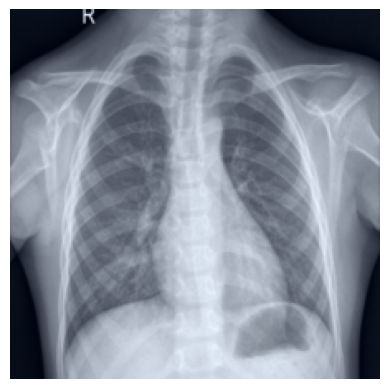

In [7]:
categorias = ['NORMAL', 'PNEUMONIA']

def plot_image(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

sample_id = np.random.randint(int(len(testLoader)))
print(f'La imagen representa: {categorias[testLoader.dataset[sample_id][1]]}')
image = testLoader.dataset[sample_id][0]
image = (image - image.min()) / (image.max() - image.min())
plot_image(image)

In [8]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   


In [9]:
model_resnet34 = models.resnet34(pretrained=True)

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_resnet34

In [ ]:
model_aux = nn.Sequential(*list(model_resnet34.children()))
model_aux

In [ ]:
model_aux = nn.Sequential(*list(model_resnet34.children())[:-1])
model_aux

In [13]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False


In [14]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(trainLoader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, valLoader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [15]:
hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 5
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 2, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [16]:
train(model1, optimiser, epochs)
accuracy(model1, testLoader)

KeyboardInterrupt: 